In [1]:
# Feature importance (coefficients)

from sklearn.linear_model import LinearRegression
from data import *
from model import *

taxi_type = YELLOW
train_sql = getSqlForModeling(taxi_type, isTrain=True)
test_sql = getSqlForModeling(taxi_type, isTrain=False)

model = LinearRegression()

# FEATURES = ['pu_location_id', 'do_location_id', 'passenger_count', 'trip_distance', 
#             'trip_duration', 'tip_amount', 'mta_tax', 'tolls_amount', 'extra', 
#             'improvement_surcharge', 'congestion_surcharge']

# Training
with DR.engn.connect() as conn:
    processed = 0
    for df in pd.read_sql(train_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        y = df[VARIABLE]

        model.fit(X, y)
        O.out(f'Trained {processed} rows')

importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.coef_
}).sort_values(by="Importance", ascending=False)
print(importance)

sql engine ready
                  Feature  Importance
3           trip_distance    2.615129
5              tip_amount    0.154588
7            tolls_amount    0.093033
2         passenger_count    0.046234
4           trip_duration    0.006524
0          pu_location_id   -0.000294
1          do_location_id   -0.000618
8                   extra   -0.066499
9   improvement_surcharge   -0.237535
10   congestion_surcharge   -0.304991
6                 mta_tax  -36.922276


In [1]:
from sklearn.linear_model import LinearRegression
from data import *
from model import *

taxi_type = YELLOW
train_sql = getSqlForModeling(taxi_type, isTrain=True)
test_sql = getSqlForModeling(taxi_type, isTrain=False)

model = LinearRegression()

# Training
with DR.engn.connect() as conn:
    processed = 0
    for df in pd.read_sql(train_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        y = df[VARIABLE]

        model.fit(X, y)
        O.out(f'Trained {processed} rows')

storeModel(model, f'{taxi_type}_{VARIABLE}_{LINEAR_REGRESSION}')

# Predictions
with DR.engn.connect() as conn:
    processed = 0
    y_test = []
    y_pred = []
    for df in pd.read_sql(test_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        y_test.append(df[VARIABLE])

        y_pred.append(model.predict(X))
        O.out(f'Predicted {processed} rows')

# Performance
merged_y_test = pd.concat(y_test, ignore_index=True)
merged_y_pred = np.concatenate(y_pred)

showPerformance(merged_y_test, merged_y_pred)

sql engine ready
Model Accuracy Metrics:
Mean Absolute Error (MAE): 1.28
Root Mean Squared Error (RMSE): 3.14
R-squared (Accuracy): 0.95


sql engine ready
Mean Squared Error: 9.876096083977329


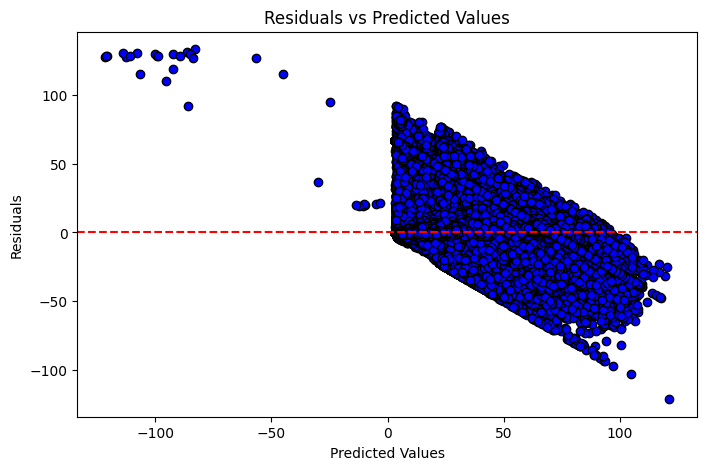

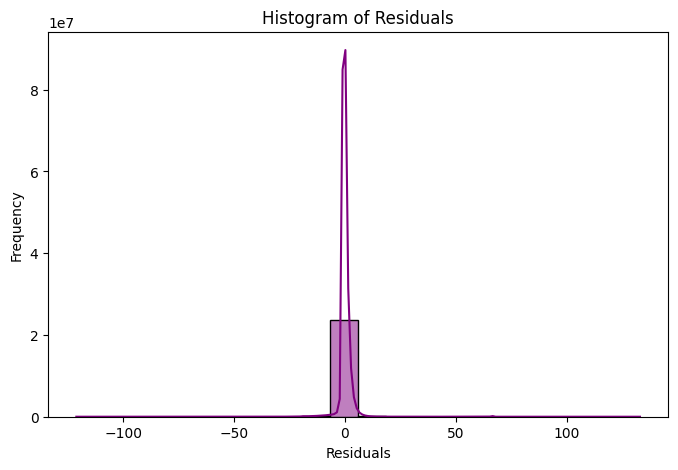

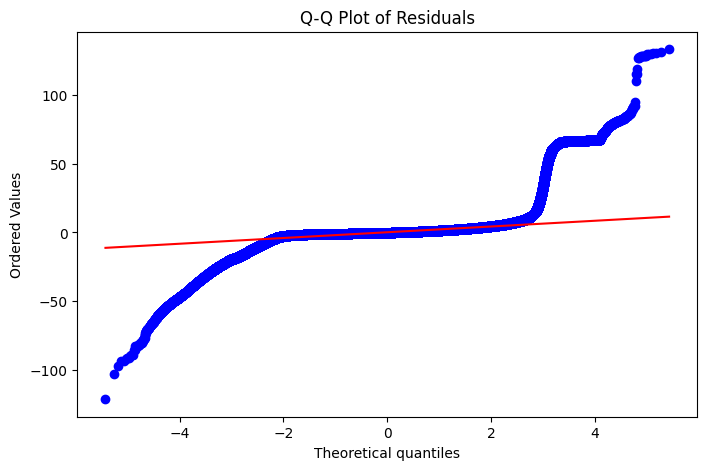

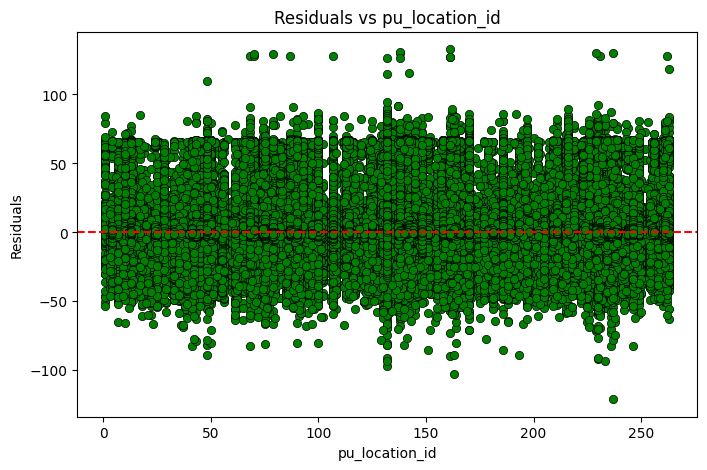

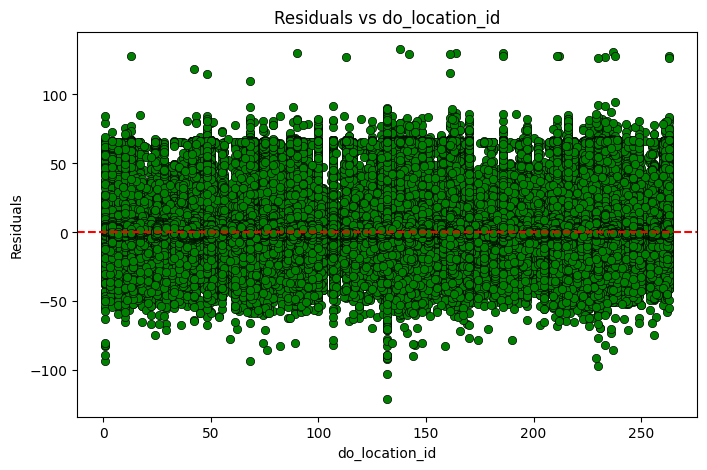

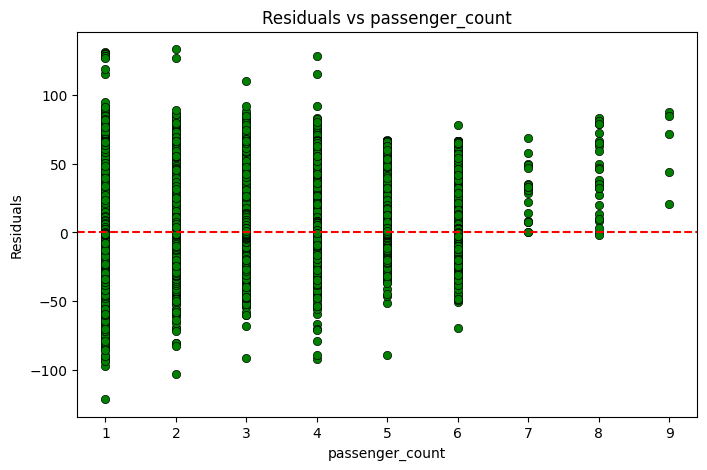

In [ ]:
# Residual Analysis
from data import *
from model import *

taxi_type = YELLOW
# train_sql = getSqlForModeling(taxi_type, isTrain=True)
test_sql = getSqlForModeling(taxi_type, isTrain=False)

model = loadModel(f'{taxi_type}_{VARIABLE}_{LINEAR_REGRESSION}')

# Predictions
with DR.engn.connect() as conn:
    processed = 0
    y_t_chunk = []
    y_p_chunk = []
    X_t_chunk = []
    for df in pd.read_sql(test_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        X_t_chunk.append(X)
        y_t_chunk.append(df[VARIABLE])

        y_p_chunk.append(model.predict(X))
        O.out(f'Predicted {processed} rows')

# Performance
X_test = pd.concat(X_t_chunk, ignore_index=True)
y_test = pd.concat(y_t_chunk, ignore_index=True)
y_pred = np.concatenate(y_p_chunk)


residualAnalysis(X_test, y_test, y_pred)